In [3]:
import pandas as pd

# File paths for the uploaded files
train_scores_path = 'train_scores.csv'
train_logs_path = 'train_logs.csv'
sample_submission_path = 'sample_submission.csv'
test_logs_path = 'test_logs.csv'

# Loading the data into Pandas DataFrames
train_scores = pd.read_csv(train_scores_path)
train_logs = pd.read_csv(train_logs_path)
sample_submission = pd.read_csv(sample_submission_path)
test_logs = pd.read_csv(test_logs_path)

# Display the first few rows of each DataFrame to understand their structure
train_scores.head(), train_logs.head(), sample_submission.head(), test_logs.head()

(         id  score
 0  001519c8    3.5
 1  0022f953    3.5
 2  0042269b    6.0
 3  0059420b    2.0
 4  0075873a    4.0,
          id  event_id  down_time  up_time  action_time       activity  \
 0  001519c8         1       4526     4557           31  Nonproduction   
 1  001519c8         2       4558     4962          404  Nonproduction   
 2  001519c8         3     106571   106571            0  Nonproduction   
 3  001519c8         4     106686   106777           91          Input   
 4  001519c8         5     107196   107323          127          Input   
 
   down_event   up_event text_change  cursor_position  word_count  
 0  Leftclick  Leftclick    NoChange                0           0  
 1  Leftclick  Leftclick    NoChange                0           0  
 2      Shift      Shift    NoChange                0           0  
 3          q          q           q                1           1  
 4          q          q           q                2           1  ,
          id  score
 0  

In [12]:
def process_logs_chunk(chunk):
    """
    Process a chunk of the train_logs data.

    :param chunk: A DataFrame chunk of the train_logs data.
    :return: A DataFrame with summarized features for each user.
    """
    # Grouping by user ID and creating summary features
    grouped = chunk.groupby('id').agg({
        'event_id': 'count',  # Count of events
        'action_time': ['mean', 'sum'],  # Mean and sum of action times
        'activity': lambda x: x.mode()[0],  # Most frequent activity
        'down_event': 'nunique',  # Count of unique down events
        'up_event': 'nunique',  # Count of unique up events
        'text_change': 'nunique',  # Count of unique text changes
        'cursor_position': 'max',  # Maximum cursor position
        'word_count': 'max'  # Maximum word count
    })

    # Flattening the multi-level column names
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    grouped.reset_index(inplace=True)

    return grouped

# Test the function with the sample data
processed_sample = process_logs_chunk(train_logs)
processed_sample


,id,event_id_count,action_time_mean,action_time_sum,activity_<lambda>,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_max,word_count_max
0,001519c8,2557,116.246774,297243,Input,12,12,17,1539,256
1,0022f953,2454,112.221271,275391,Input,17,17,12,1676,323
2,0042269b,4136,101.837766,421201,Input,13,18,19,2291,404
3,0059420b,1556,121.848329,189596,Input,15,15,10,1047,206
4,0075873a,2531,123.943896,313702,Input,11,11,9,1402,252
...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,4739,105.437856,499670,Input,13,13,13,1634,461
2467,ffbef7e5,2604,82.266129,214221,Input,11,11,8,1877,438
2468,ffccd6fd,3063,75.605615,231580,Input,11,11,6,2761,201
2469,ffec5b38,3242,89.277915,289439,Input,15,15,13,2133,413


In [8]:



from sklearn.model_selection import train_test_split
import numpy as np

def process_chunk(chunk):
    # Aggregating data for each user
    agg_funcs = {
        'down_time': ['mean', 'std', 'min', 'max'],
        'up_time': ['mean', 'std', 'min', 'max'],
        'action_time': ['mean', 'std', 'min', 'max'],
        'activity': lambda x: x.mode()[0] if not x.mode().empty else np.nan,  # Most frequent activity
        'down_event': 'count',  # Counting the number of events
        'up_event': lambda x: x.nunique(),  # Number of unique up events
        'text_change': lambda x: x[x != ' '].count(),  # Count of non-space text changes
        'cursor_position': ['mean', 'std'],
        'word_count': ['mean', 'std', 'max']
    }
    return chunk.groupby('id').agg(agg_funcs)


chunk_size = 5000  
chunks = pd.read_csv(train_logs_path, chunksize=chunk_size)


processed_train_logs = pd.DataFrame()


for chunk in chunks:
    processed_chunk = process_chunk(chunk)
    processed_train_logs = pd.concat([processed_train_logs, processed_chunk])

# Resetting the index to make 'id' a column again
processed_train_logs.reset_index(inplace=True)

# Now, we'll split the dataset into training and testing sets
# We'll use 80% of the data for training and the remaining 20% for testing
train_data, test_data = train_test_split(processed_train_logs, test_size=0.2, random_state=42)

# Let's check the first few rows of the processed train data
train_data.head()


id     down_time                                        up_time  \
                        mean            std      min      max          mean   
3439  d6b3f0ee  7.496072e+05  437078.091685     3609  1802719  7.497559e+05   
2987  bab8c2fd  1.180161e+06  212750.025180   682875  1797274  1.180253e+06   
2474  9cd5ac07  4.632043e+05  183216.287965    14678   791792  4.633047e+05   
1454  5c5e3889  1.700614e+06   17849.034591  1679236  1718770  1.700720e+06   
1721  6c6a19c5  1.478359e+06  182158.470905  1154060  1864372  1.478503e+06   

                                      action_time  ...             activity  \
                std      min      max        mean  ...   max       <lambda>   
3439  437075.425263     3750  1802805  148.699488  ...  1304          Input   
2987  212742.421562   682983  1797322   91.587147  ...   502  Nonproduction   
2474  183208.938559    14788   791892  100.389465  ...  1616          Input   
1454   17851.764799  1679370  1718898  106.295455  ...   231          Input   
1721  182179.655069  1154153  1864475  143.443951  ...  3223          Input   

     down_event up_event text_change cursor_position              word_count  \
          count <lambda>    <lambda>            mean         std        mean   
3439       2539       12        2156      768.576211  448.588812  141.058685   
2987       3081       17        2942     1434.642324  990.509824  480.572866   
2474       1158       14         980      387.784111  187.085262   67.231434   
1454         44        5          37     1739.772727  212.630027  400.909091   
1721        901       17         844     1332.173141  136.532434  231.127636   

                      
            std  max  
3439  79.253482  272  
2987  48.572378  521  
2474  31.556126  112  
1454   2.531827  404  
1721  10.509695  240  

[5 rows x 22 columns]

KeyError: 'down_time_mean'

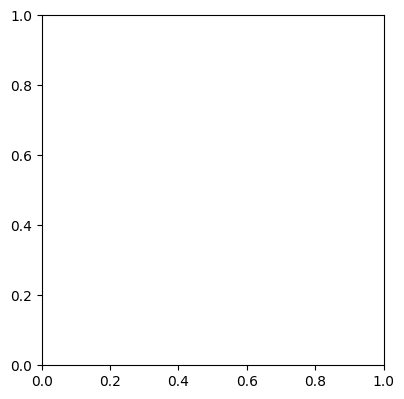

In [11]:
# Flattening the multi-level column names

import matplotlib.pyplot as plt
processed_train_logs.columns = ['_'.join(col).strip() for col in processed_train_logs.columns.values]

# Updating the train and test data with the new column structure
train_data, test_data = train_test_split(processed_train_logs, test_size=0.2, random_state=42)

# Updating the list of features to plot based on the new column names
features_to_plot = ['down_time_mean', 'up_time_mean', 'action_time_mean', 'down_event_count', 'up_event_<lambda>']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    plt.hist(train_data[feature], bins=30, edgecolor='black')
    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Outputting the summary statistics of the processed train data
train_data.describe()
